In [ ]:
#hide
#default_exp visualization.experiment_visualization
from nbdev.showdoc import show_doc
import warnings
warnings.filterwarnings('ignore')

# Visualization utils

## Plot history

In [ ]:
#export
import numpy as np
#import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
from IPython.display import display
import visdom
from hpsearch.config.hpconfig import get_path_results, get_path_experiments
import hpsearch.utils.experiment_utils as ut
from hpsearch.visualization import plot_utils 
import warnings
warnings.filterwarnings('ignore')
    
              
def plot_multiple_histories (experiments, run_number=0, root_path=None, root_folder=None, metrics='all', 
                             metrics_second=[], parameters = None, compare = True, 
                             ylegend=0.5, name_file='model_history.pk', 
                             op='max', include_parameters_in_legend=False,
                             backend='visdom'):
    
    if root_path is None:
        root_path = get_path_experiments(folder=root_folder)
    
    df = pd.read_csv('%s/experiments_data.csv' %root_path,index_col=0)
    df2 = ut.get_experiment_parameters (df.loc[experiments], only_not_null=True)
    parameters2, df2 = ut.get_parameters_unique(df2)

    if compare or parameters is not None:        
        if parameters is None:
            parameters = parameters2 
        df = df.loc[experiments,parameters]
    
    if type(metrics)==str and (metrics == 'all'):
        path_results = get_path_results (experiments[0], run_number=run_number, root_path=root_path)
        history = pickle.load(open('%s/%s' %(path_results, name_file),'rb'))
        metrics = history.keys()
    if type(metrics) == str:
        metrics = [metrics]
    if type(metrics_second) == str:
        metrics_second = [metrics_second]
    df = ut.replace_with_default_values (df)
    df2 = ut.replace_with_default_values (df2)
    df_show = df.copy()
    
    for (imetric,metric) in enumerate(metrics):
        title = metric
        traces = []
        for experiment_id in experiments:
            path_results = get_path_results (experiment_id, run_number=run_number, root_path=root_path)
            if os.path.exists('%s/%s' %(path_results, name_file)):
                history = pickle.load(open('%s/%s' %(path_results, name_file),'rb'))
                values = [float(x) for x in history[metric]]
                if compare and include_parameters_in_legend:
                    label = '{}-{}'.format(experiment_id, list(dict(df.loc[experiment_id]).values()))
                else:
                    label = '{}'.format(experiment_id)
                traces = plot_utils.add_trace (history[metric], style='A.-', label=label, backend=backend, traces=traces)
                
                if True:
                    if op == 'min':
                        imin = int(np.array(history[metric]).argmin())
                    else:
                        imin = int(np.array(history[metric]).argmax())
                    vmin = float(history[metric][imin])
                    traces = plot_utils.add_trace ([imin], [vmin], style='.', label='', backend=backend, 
                                                   marker={'color': 'red', 'symbol': 104, 'size': 10},
                                                   traces=traces)
                    
                    title += ' [%d]: %.2f' %(experiment_id, vmin)
                    df_show.loc[experiment_id, metric] = vmin
                    df2.loc[experiment_id, metric] = vmin
                if (imetric == 0):
                    for metric_second in metrics_second:
                        values = [float(x) for x in history[metric_second]]
                        if compare and include_parameters_in_legend:
                            label = '{}: {}-{}'.format(metric_second, experiment_id, list(dict(df.loc[experiment_id]).values()))
                        else:
                            label = '{}: {}'.format(metric_second, experiment_id)
                        traces = plot_utils.add_trace (history[metric_second], style='A.-', label=label, backend=backend, traces=traces)
                        
                        if op == 'min':
                            imin = int(np.array(history[metric_second]).argmin())
                        else:
                            imin = int(np.array(history[metric_second]).argmax())
                        vmin = float(history[metric_second][imin])
                        traces = plot_utils.add_trace ([imin], [vmin], style='.', label='', backend=backend, 
                                                   marker={'color': 'red', 'symbol': 104, 'size': 10},
                                                   traces=traces)
                        title += ' [%d]: %.2f' %(experiment_id, vmin)
                        df_show.loc[experiment_id, metric_second] = vmin
                        df2.loc[experiment_id, metric_second] = vmin

        plot_utils.plot(title=title, xlabel='epoch', ylabel=metric, traces=traces, backend=backend)
        if backend=='visdom':
            vis = visdom.Visdom()
            vis.text (df_show.to_html(justify='left', col_space=100), win= f'{metric}_parameters')
        display(df2)


In [ ]:
#collapse_output
from hpsearch.examples.dummy_experiment_manager import remove_previous_experiments, run_multiple_experiments

remove_previous_experiments()
run_multiple_experiments(nruns=5, noise=0.1)
run_multiple_experiments(nruns=5, noise=0.1, rate = 0.1)

experiment script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line: 170
processing hyper-parameter 0 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0011146068572998047
0 - validation_accuracy: 0.26437898169579377
0 - test_accuracy: 0.35304522694943397
finished experiment 0
processing hyper-parameter 0 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0009634494781494141
1 - validation_accuracy: 0.1392998029036163
1 - test_accuracy: 0.3470026800613887
finished experiment 0
processing hyper-para

current path: /mnt/athena/hpsearch/nbs/visualization
current path: /mnt/athena/hpsearch/nbs/visualization
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25


finished experiment 0
processing hyper-parameter 0 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 0
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0009491443634033203
4 - validation_accuracy: 0.16307826288535615
4 - test_accuracy: 0.40808294024029795
finished experiment 0
processing hyper-parameter 1 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0009326934814453125
0 - validation_accuracy: 0.43530591477787334
0 - test_accuracy: 0.5629307593930236
finished experiment 1
processing hyper-parameter 1 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
r

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007


finished experiment 1
processing hyper-parameter 1 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0011415481567382812
3 - validation_accuracy: 0.46309654166193814
3 - test_accuracy: 0.37285016748809985
finished experiment 1
processing hyper-parameter 1 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 1
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0008649826049804688
4 - validation_accuracy: 0.5952470900687068
4 - test_accuracy: 0.4524649573376984
finished experiment 1
processing hyper-parameter 2 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
ru

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001


running experiment 2
run number: 2

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.001256704330444336
2 - validation_accuracy: 0.7829024889352322
2 - test_accuracy: 0.8303805721999866
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0012331008911132812
3 - validation_accuracy: 0.6939280819627526
3 - test_accuracy: 0.9545875888418626
finished experiment 2
processing hyper-parameter 2 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 2
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsea

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
current path: /mnt/athena/hpsearch/nbs/visualization


script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0019600391387939453
0 - validation_accuracy: 0.45286977284745117
0 - test_accuracy: 0.48066476408159103
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0018999576568603516
1 - validation_accuracy: 0.500507517629903
1 - test_accuracy: 0.3170219425294045
finished experiment 3
processing hyper-parameter 3 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 3
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this exper

fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy

running experiment 3
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.002001047134399414
4 - validation_accuracy: 0.5416096554062103
4 - test_accuracy: 0.35394806290013764
finished experiment 3
processing hyper-parameter 4 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.002063274383544922
0 - validation_accuracy: 0.6601760467306448
0 - test_accuracy: 0.6437296838851856
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hp

fitting model with 15 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
e

finished experiment 4
processing hyper-parameter 4 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0018892288208007812
3 - validation_accuracy: 0.7858307275840313
3 - test_accuracy: 0.7762018425593518
finished experiment 4
processing hyper-parameter 4 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 4
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0019278526306152344
4 - validation_accuracy: 0.5360170298504554
4 - test_accuracy: 0.56273105405402
finished experiment 4
processing hyper-parameter 5 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
runn

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8

running experiment 5
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0019989013671875
1 - validation_accuracy: 1.0
1 - test_accuracy: 0.9339351947330581
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.002192258834838867
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 5
processing hyper-parameter 5 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 5
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manage

fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000

finished experiment 5
processing hyper-parameter 6 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003911256790161133
0 - validation_accuracy: 0.40753349293378344
0 - test_accuracy: 0.4540270586341919
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003615140914916992
1 - validation_accuracy: 0.27914680472603803
1 - test_accuracy: 0.25304431718360393
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
r

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.520000000000

finished experiment 6
processing hyper-parameter 6 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0038216114044189453
3 - validation_accuracy: 0.35684320080393656
3 - test_accuracy: 0.30561581270463056
finished experiment 6
processing hyper-parameter 6 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 6
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.004158973693847656
4 - validation_accuracy: 0.26821556074236624
4 - test_accuracy: 0.34367685171589435
finished experiment 6
processing hyper-parameter 7 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 30 epochs
epoch 0: accuracy: 0.13
epoch 1: accuracy: 0.16
epoch 2: accuracy: 0.19
epoch 3: accuracy: 0.22
epoch 4: accuracy: 0.25
epoch 5: accuracy: 0.28
epoch 6: accuracy: 0.31000000000000005
epoch 7: accuracy: 0.3400000000000001
epoch 8: accuracy: 0.3700000000000001
epoch 9: accuracy: 0.40000000000000013
epoch 10: accuracy: 0.43000000000000016
epoch 11: accuracy: 0.4600000000000002
epoch 12: accuracy: 0.4900000000000002
epoch 13: accuracy: 0.5200000000000002
epoch 14: accuracy: 0.5500000000000003
epoch 15: accuracy: 0.5800000000000003
epoch 16: accuracy: 0.6100000000000003
epoch 17: accuracy: 0.6400000000000003
epoch 18: accuracy: 0.6700000000000004
epoch 19: accuracy: 0.7000000000000004
epoch 20: accuracy: 0.6700000000000004
epoch 21: accuracy: 0.6400000000000003
epoch 22: accuracy: 0.6100000000000003
epoch 23: accuracy: 0.5800000000000003
epoch 24: accuracy: 0.5500000000000003
epoch 25: accuracy: 0.520000000000

running experiment 7
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0034155845642089844
1 - validation_accuracy: 0.4802218679872151
1 - test_accuracy: 0.4697148344364077
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003989219665527344
2 - validation_accuracy: 0.7297568082638686
2 - test_accuracy: 0.6531497119629971
finished experiment 7
processing hyper-parameter 7 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 7
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hp

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 30 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
epoch 15: accuracy: 0.7800000000000004
epoch 16: accuracy: 0.8100000000000004
epoch 17: accuracy: 0.8400000000000004
epoch 18: accuracy: 0.8700000000000004
epoch 19: accuracy: 0.9000000000000005
epoch 20: accuracy: 0.8700000000000004
epoch 21: accuracy: 0.8400000000000004
epoch 22: accuracy: 0.8100000000000004
epoch 23: accuracy: 0.7800000000000004
epoch 24: accurac

running experiment 7
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003730297088623047
4 - validation_accuracy: 0.3723493488012269
4 - test_accuracy: 0.5614181118456143
finished experiment 7
processing hyper-parameter 8 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003468751907348633
0 - validation_accuracy: 0.6947290123140064
0 - test_accuracy: 0.8101662299230422
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hps

fitting model with 30 epochs
epoch 0: accuracy: 0.32999999999999996
epoch 1: accuracy: 0.36
epoch 2: accuracy: 0.39
epoch 3: accuracy: 0.42000000000000004
epoch 4: accuracy: 0.45000000000000007
epoch 5: accuracy: 0.4800000000000001
epoch 6: accuracy: 0.5100000000000001
epoch 7: accuracy: 0.5400000000000001
epoch 8: accuracy: 0.5700000000000002
epoch 9: accuracy: 0.6000000000000002
epoch 10: accuracy: 0.6300000000000002
epoch 11: accuracy: 0.6600000000000003
epoch 12: accuracy: 0.6900000000000003
epoch 13: accuracy: 0.7200000000000003
epoch 14: accuracy: 0.7500000000000003
epoch 15: accuracy: 0.7800000000000004
epoch 16: accuracy: 0.8100000000000004
epoch 17: accuracy: 0.8400000000000004
epoch 18: accuracy: 0.8700000000000004
epoch 19: accuracy: 0.9000000000000005
epoch 20: accuracy: 0.8700000000000004
epoch 21: accuracy: 0.8400000000000004
epoch 22: accuracy: 0.8100000000000004
epoch 23: accuracy: 0.7800000000000004
epoch 24: accuracy: 0.7500000000000003
epoch 25: accuracy: 0.720000000

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003511190414428711
2 - validation_accuracy: 1.0
2 - test_accuracy: 0.7296051348996728
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003732442855834961
3 - validation_accuracy: 0.9306083986740118
3 - test_accuracy: 0.669359963200913
finished experiment 8
processing hyper-parameter 8 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 8
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.03

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0034244060

fitting model with 30 epochs
epoch 0: accuracy: 0.63
epoch 1: accuracy: 0.66
epoch 2: accuracy: 0.6900000000000001
epoch 3: accuracy: 0.7200000000000001
epoch 4: accuracy: 0.7500000000000001
epoch 5: accuracy: 0.7800000000000001
epoch 6: accuracy: 0.8100000000000002
epoch 7: accuracy: 0.8400000000000002
epoch 8: accuracy: 0.8700000000000002
epoch 9: accuracy: 0.9000000000000002
epoch 10: accuracy: 0.9300000000000003
epoch 11: accuracy: 0.9600000000000003
epoch 12: accuracy: 0.9900000000000003
epoch 13: accuracy: 1.0200000000000002
epoch 14: accuracy: 1.0500000000000003
epoch 15: accuracy: 1.0800000000000003
epoch 16: accuracy: 1.1100000000000003
epoch 17: accuracy: 1.1400000000000003
epoch 18: accuracy: 1.1700000000000004
epoch 19: accuracy: 1.2000000000000004
epoch 20: accuracy: 1.1700000000000004
epoch 21: accuracy: 1.1400000000000003
epoch 22: accuracy: 1.1100000000000003
epoch 23: accuracy: 1.0800000000000003
epoch 24: accuracy: 1.0500000000000003
epoch 25: accuracy: 1.020000000000

experiment script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line: 170
processing hyper-parameter 0 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0009095668792724609
0 - validation_accuracy: 0.4729764694502593
0 - test_accuracy: 0.8558039995376592
finished experiment 9
processing hyper-parameter 0 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0008921623229980469
1 - validation_accuracy: 0.5143888710959071
1 - test_accuracy: 0.6971675203322029
finished experiment 9
processing hyper-paramete

current path: /mnt/athena/hpsearch/nbs/visualization
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6


finished experiment 9
processing hyper-parameter 0 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0009410381317138672
3 - validation_accuracy: 0.5960275729484116
3 - test_accuracy: 0.7726460539922709
finished experiment 9
processing hyper-parameter 0 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 9
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0009109973907470703
4 - validation_accuracy: 0.42255630753557644
4 - test_accuracy: 0.7280725316243567
finished experiment 9
processing hyper-parameter 1 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
runni

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999


finished experiment 10
processing hyper-parameter 1 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 10
run number: 1

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0008819103240966797
1 - validation_accuracy: 0.8087455740856595
1 - test_accuracy: 0.9595807171145965
finished experiment 10
processing hyper-parameter 1 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 10
run number: 2

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0009200572967529297
2 - validation_accuracy: 0.8565821600423733
2 - test_accuracy: 0.7767473874212727
finished experiment 10
processing hyper-parameter 1 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
r

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999


finished experiment 10
processing hyper-parameter 1 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 10
run number: 4

parameters:
	epochs=5,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.00101470947265625
4 - validation_accuracy: 0.7984915074076592
4 - test_accuracy: 0.7632499444830612
finished experiment 10
processing hyper-parameter 2 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 11
run number: 0

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0010426044464111328
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 2 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 11
run number:

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999


finished experiment 11
processing hyper-parameter 2 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 11
run number: 2

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0009377002716064453
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 2 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 11
run number: 3

parameters:
	epochs=5,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0009272098541259766
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 11
processing hyper-parameter 2 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 11
run number: 4

parameters:
	epochs=5,
	

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 5 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999


finished experiment 11
processing hyper-parameter 3 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.002508878707885742
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 3 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0018928050994873047
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 3 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 2

parameters:
	epochs=15,

current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: a

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.002164125442504883
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 3 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0019173622131347656
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 12
processing hyper-parameter 3 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 12
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0019822120666503906
4 - validation_accuracy: 1.0
4 

fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.500

running experiment 13
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.002238035202026367
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 4 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 13
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0020008087158203125
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 4 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 13
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line

fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.60000000000000

running experiment 13
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.001890420913696289
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 4 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 13
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0025942325592041016
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 13
processing hyper-parameter 5 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 14
run number: 0

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line

fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.60000000000000

running experiment 14
run number: 1

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0019762516021728516
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 14
processing hyper-parameter 5 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 14
run number: 2

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.001949310302734375
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 14
processing hyper-parameter 5 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 14
run number: 3

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line

fitting model with 15 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 15 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.70

running experiment 14
run number: 4

parameters:
	epochs=15,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0019178390502929688
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 14
processing hyper-parameter 6 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0033636093139648438
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 15
processing hyper-parameter 6 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, lin

fitting model with 15 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
current path: /mnt/athena/hpsearch/nbs/visualization
fitting model with 30 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch

running experiment 15
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003696441650390625
2 - validation_accuracy: 0.9915982344641578
2 - test_accuracy: 0.9357029914189887
finished experiment 15
processing hyper-parameter 6 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003444671630859375
3 - validation_accuracy: 1.0
3 - test_accuracy: 0.9191055728594711
finished experiment 15
processing hyper-parameter 6 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 15
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.1,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearc

fitting model with 30 epochs
epoch 0: accuracy: 0.2
epoch 1: accuracy: 0.30000000000000004
epoch 2: accuracy: 0.4
epoch 3: accuracy: 0.5
epoch 4: accuracy: 0.6
epoch 5: accuracy: 0.7
epoch 6: accuracy: 0.7999999999999999
epoch 7: accuracy: 0.8999999999999999
epoch 8: accuracy: 0.9999999999999999
epoch 9: accuracy: 1.0999999999999999
epoch 10: accuracy: 1.2
epoch 11: accuracy: 1.3
epoch 12: accuracy: 1.4000000000000001
epoch 13: accuracy: 1.5000000000000002
epoch 14: accuracy: 1.6000000000000003
epoch 15: accuracy: 1.7000000000000004
epoch 16: accuracy: 1.8000000000000005
epoch 17: accuracy: 1.9000000000000006
epoch 18: accuracy: 2.0000000000000004
epoch 19: accuracy: 2.1000000000000005
epoch 20: accuracy: 2.0000000000000004
epoch 21: accuracy: 1.9000000000000004
epoch 22: accuracy: 1.8000000000000003
epoch 23: accuracy: 1.7000000000000002
epoch 24: accuracy: 1.6
epoch 25: accuracy: 1.5
epoch 26: accuracy: 1.4
epoch 27: accuracy: 1.2999999999999998
epoch 28: accuracy: 1.1999999999999997

running experiment 16
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0034780502319335938
0 - validation_accuracy: 1.0
0 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 7 out of 9
doing run 1 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003801584243774414
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 7 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line

fitting model with 30 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
epoch 15: accuracy: 1.9000000000000006
epoch 16: accuracy: 2.0000000000000004
epoch 17: accuracy: 2.1000000000000005
epoch 18: accuracy: 2.2000000000000006
epoch 19: accuracy: 2.3000000000000007
epoch 20: accuracy: 2.2000000000000006
epoch 21: accuracy: 2.1000000000000005
epoch 22: accuracy: 2.0000000000000004
epoch 23: accuracy: 1.9000000000000004
epoch 24: accuracy: 1.8000000000000003
epoch 25: accuracy: 1.7000000000000002
epoch 26: accuracy: 1.6
epoch 27: accuracy: 1.5
epoch 28:

running experiment 16
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003237485885620117
3 - validation_accuracy: 1.0
3 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 7 out of 9
doing run 4 out of 5
fixed rate, multiple epochs values
running experiment 16
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.3,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003351449966430664
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 16
processing hyper-parameter 8 out of 9
doing run 0 out of 5
fixed rate, multiple epochs values
running experiment 17
run number: 0

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line 

fitting model with 30 epochs
epoch 0: accuracy: 0.4
epoch 1: accuracy: 0.5
epoch 2: accuracy: 0.6
epoch 3: accuracy: 0.7
epoch 4: accuracy: 0.7999999999999999
epoch 5: accuracy: 0.8999999999999999
epoch 6: accuracy: 0.9999999999999999
epoch 7: accuracy: 1.0999999999999999
epoch 8: accuracy: 1.2
epoch 9: accuracy: 1.3
epoch 10: accuracy: 1.4000000000000001
epoch 11: accuracy: 1.5000000000000002
epoch 12: accuracy: 1.6000000000000003
epoch 13: accuracy: 1.7000000000000004
epoch 14: accuracy: 1.8000000000000005
epoch 15: accuracy: 1.9000000000000006
epoch 16: accuracy: 2.0000000000000004
epoch 17: accuracy: 2.1000000000000005
epoch 18: accuracy: 2.2000000000000006
epoch 19: accuracy: 2.3000000000000007
epoch 20: accuracy: 2.2000000000000006
epoch 21: accuracy: 2.1000000000000005
epoch 22: accuracy: 2.0000000000000004
epoch 23: accuracy: 1.9000000000000004
epoch 24: accuracy: 1.8000000000000003
epoch 25: accuracy: 1.7000000000000002
epoch 26: accuracy: 1.6
epoch 27: accuracy: 1.5
epoch 28:

running experiment 17
run number: 1

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0034911632537841797
1 - validation_accuracy: 1.0
1 - test_accuracy: 1.0
finished experiment 17
processing hyper-parameter 8 out of 9
doing run 2 out of 5
fixed rate, multiple epochs values
running experiment 17
run number: 2

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.0037336349487304688
2 - validation_accuracy: 1.0
2 - test_accuracy: 1.0
finished experiment 17
processing hyper-parameter 8 out of 9
doing run 3 out of 5
fixed rate, multiple epochs values
running experiment 17
run number: 3

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, lin

fitting model with 30 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
epoch 15: accuracy: 2.2000000000000006
epoch 16: accuracy: 2.3000000000000007
epoch 17: accuracy: 2.400000000000001
epoch 18: accuracy: 2.500000000000001
epoch 19: accuracy: 2.600000000000001
epoch 20: accuracy: 2.500000000000001
epoch 21: accuracy: 2.400000000000001
epoch 22: accuracy: 2.3000000000000007
epoch 23: accuracy: 2.2000000000000006
epoch 24: accuracy: 2.1000000000000005
epoch 25: accuracy: 2.0000000000000004
epoch 26: accurac

running experiment 17
run number: 4

parameters:
	epochs=30,
	noise=0.1,
	offset=0.6,
	rate=0.1

script: /mnt/athena/hpsearch/hpsearch/examples/dummy_experiment_manager.py, line number: 170
time spent on this experiment: 0.003448486328125
4 - validation_accuracy: 1.0
4 - test_accuracy: 1.0
finished experiment 17


fitting model with 30 epochs
epoch 0: accuracy: 0.7
epoch 1: accuracy: 0.7999999999999999
epoch 2: accuracy: 0.8999999999999999
epoch 3: accuracy: 0.9999999999999999
epoch 4: accuracy: 1.0999999999999999
epoch 5: accuracy: 1.2
epoch 6: accuracy: 1.3
epoch 7: accuracy: 1.4000000000000001
epoch 8: accuracy: 1.5000000000000002
epoch 9: accuracy: 1.6000000000000003
epoch 10: accuracy: 1.7000000000000004
epoch 11: accuracy: 1.8000000000000005
epoch 12: accuracy: 1.9000000000000006
epoch 13: accuracy: 2.0000000000000004
epoch 14: accuracy: 2.1000000000000005
epoch 15: accuracy: 2.2000000000000006
epoch 16: accuracy: 2.3000000000000007
epoch 17: accuracy: 2.400000000000001
epoch 18: accuracy: 2.500000000000001
epoch 19: accuracy: 2.600000000000001
epoch 20: accuracy: 2.500000000000001
epoch 21: accuracy: 2.400000000000001
epoch 22: accuracy: 2.3000000000000007
epoch 23: accuracy: 2.2000000000000006
epoch 24: accuracy: 2.1000000000000005
epoch 25: accuracy: 2.0000000000000004
epoch 26: accurac

### Usage examples

Plot all the metrics that have been stored in model_history

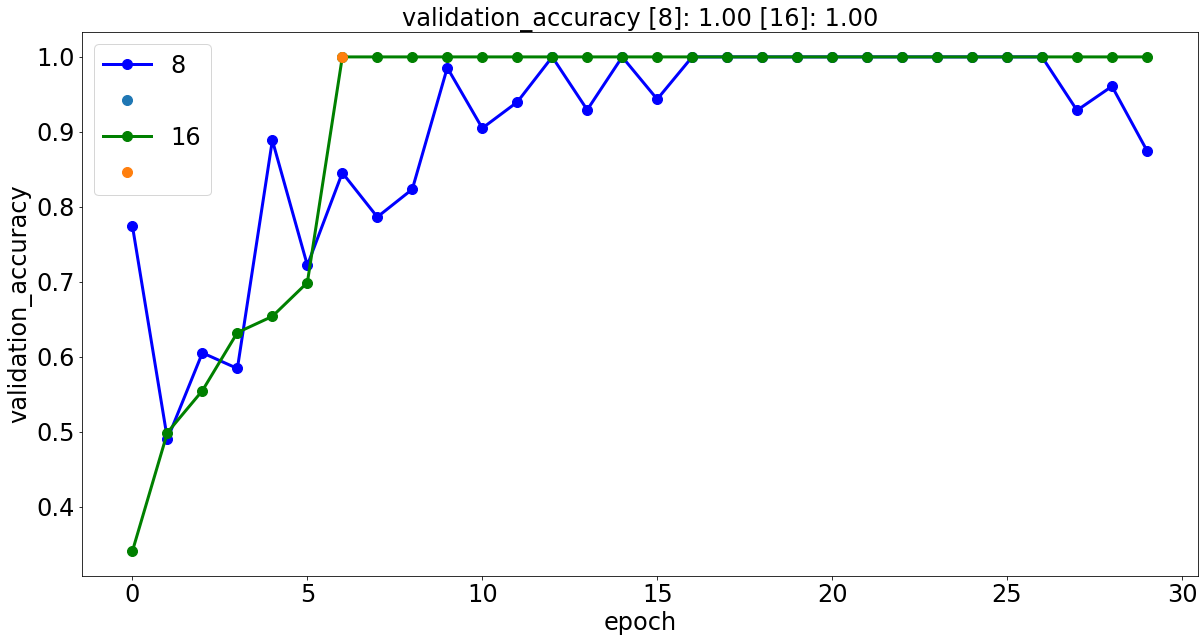

,offset,rate,validation_accuracy
8,0.6,0.03,1.0
16,0.3,0.10,1.0


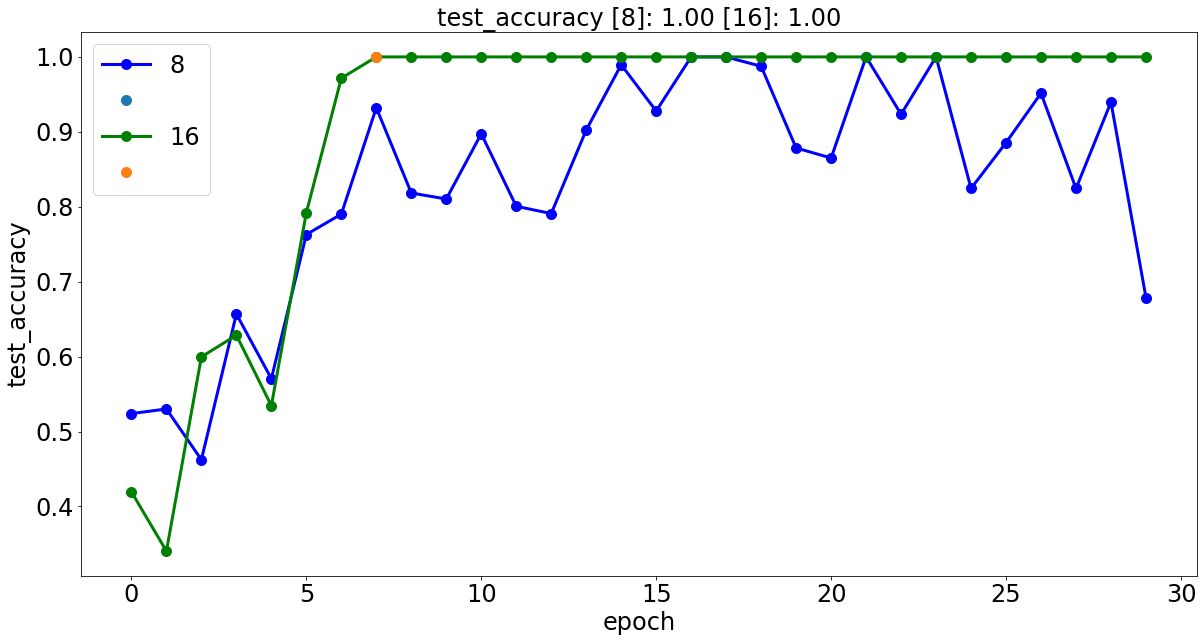

,offset,rate,validation_accuracy,test_accuracy
8,0.6,0.03,1.0,1.0
16,0.3,0.10,1.0,1.0


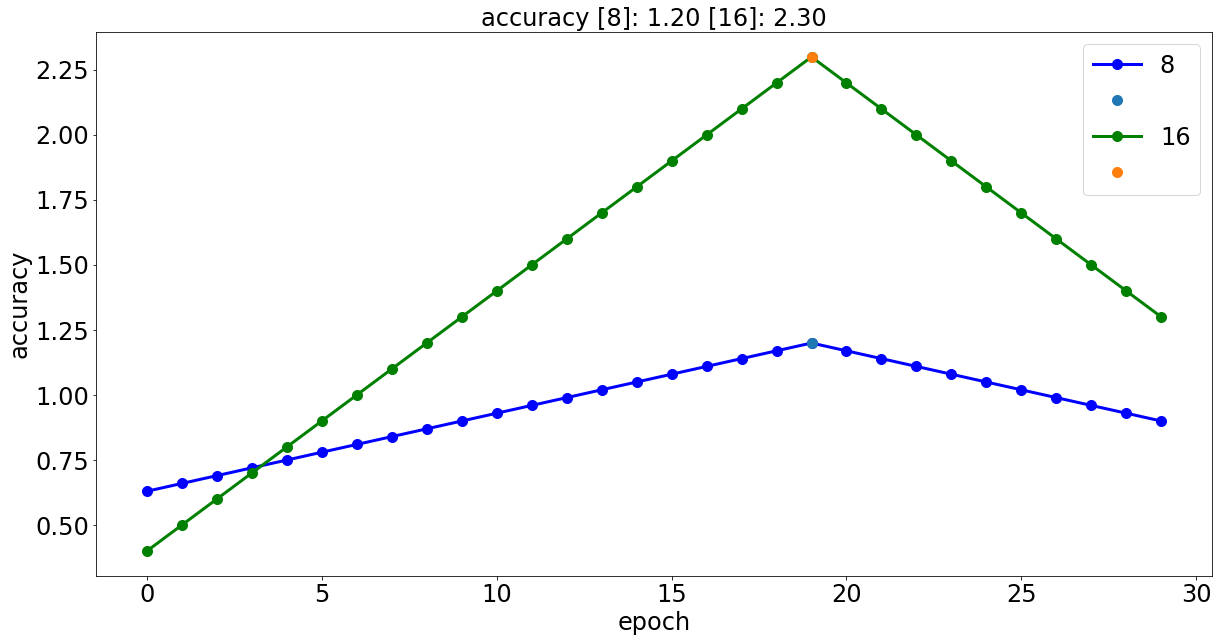

,offset,rate,validation_accuracy,test_accuracy,accuracy
8,0.6,0.03,1.0,1.0,1.2
16,0.3,0.10,1.0,1.0,2.3


In [ ]:
plot_multiple_histories ([8,16], run_number=0, op='max', backend='matplotlib')

### Plot only one metric, and three experiments

We plot the test_accuracy metric

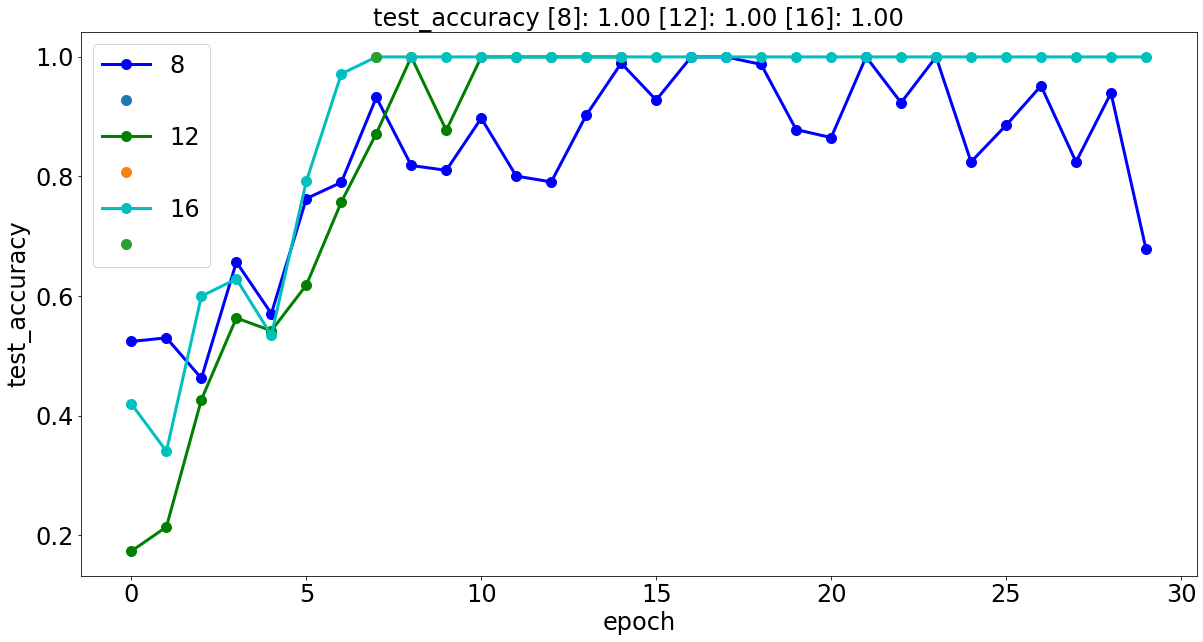

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


In [ ]:
plot_multiple_histories ([8,12, 16], run_number=0, op='max', metrics = 'test_accuracy', backend='matplotlib')

### Use plotly as backend

In [ ]:
plot_multiple_histories ([8,12, 16], run_number=0, op='max', metrics = 'test_accuracy', backend='plotly')

,epochs,offset,rate,test_accuracy
8,30.0,0.6,0.03,1.0
12,15.0,0.1,0.10,1.0
16,30.0,0.3,0.10,1.0


## Metric correlation

Displays the relationship between scores obtained across experiments with two different evaluation metrics indicated as argument. Calculates Pearson R-squared coefficient.

In [ ]:
#export
from hpsearch.utils import experiment_utils as ut
from hpsearch.visualization import plotly
import numpy as np

def plot_metric_relationship (metric_1, metric_2, folder_experiments=None, run_numbers=None, 
                              experiments=None, experiment_subset=None,
                              backend='visdom'):
    df = ut.get_experiment_data (folder_experiments=folder_experiments, experiments=experiments)
    df_metric_1 = ut.get_experiment_scores (experiment_data=df, suffix_results=f'_{metric_1}', remove_suffix=True, class_ids=run_numbers)
    df_metric_2 = ut.get_experiment_scores (experiment_data=df, suffix_results=f'_{metric_2}', remove_suffix=True, class_ids=run_numbers)
    
    traces=plotly.add_trace(df_metric_1.values, df_metric_2.values, traces=[], style='A.', label='all experiments', backend=backend);
    
    if experiment_subset is not None:
        df_metric_1_subset = ut.get_experiment_scores (experiment_data=df.loc[experiment_subset], suffix_results=f'_{metric_1}', remove_suffix=True, class_ids=run_numbers)
        df_metric_2_subset = ut.get_experiment_scores (experiment_data=df.loc[experiment_subset], suffix_results=f'_{metric_2}', remove_suffix=True, class_ids=run_numbers)
        traces=plotly.add_trace(df_metric_1_subset.values, df_metric_2_subset.values, traces=traces, style='A.', label=f'selected subset', backend=backend);
    
    plotly.plot(np.linspace(df_metric_1.values.min(), df_metric_1.values.max(), 100), 
                np.linspace(df_metric_2.values.min(), df_metric_2.values.max(), 100), 
                traces=traces, style='A-', label='linear', title=f'{metric_1} vs {metric_2}', xlabel=metric_1, ylabel=metric_2, backend=backend);

## usage examples

Illustrate usage based on dummy experiment manager

#### plot relationship between validation and accuracy metrics

In [ ]:
plot_metric_relationship (metric_1, metric_2, backend='plotly')

#### 3. Highlight selected experiments

In [ ]:
plot_metric_relationship (metric_1, metric_2, experiment_subset=[5,2], backend='plotly')

In [ ]:
#hide
from nbdev.export import *
notebook2script(recursive=True)

Converted hpconfig.ipynb.
Converted manager_factory.ipynb.
Converted dummy_experiment_manager.ipynb.
Converted example_experiment.ipynb.
Converted example_experiment_manager.ipynb.
Converted experiment_manager.ipynb.
Converted index.ipynb.
Converted change_manager.ipynb.
Converted metric_visualization.ipynb.
Converted print_parameters.ipynb.
Converted query.ipynb.
Converted experiment_utils.ipynb.
Converted organize_experiments.ipynb.
Converted experiment_visualization.ipynb.
Converted plot_utils.ipynb.
